In [3]:
# retrieve the ISIC dataset stuff
!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_Input.zip
!unzip ISIC_2024_Training_Input.zip

!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_Supplement.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_GroundTruth.csv

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "unzip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [ ]:
!pip install timm

In [6]:
# params
FREEZE = True # whether or not to freeze the weights
EPOCHS = 10 # number of training epochs
DUPE = True

In [3]:
# setup the model to be transfer learned
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
import timm


c:\Users\rngki\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define a transform to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset
dataset = CustomImageDataset(root_dir='./ISIC_2024_Training_Input/', transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# Calculate mean and standard deviation
mean = 0.0
std = 0.0
nb_samples = 0

for data in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# Print the calculated mean and standard deviation
print(f'Mean: {mean}')
print(f'Std: {std}')

In [31]:

df = pd.read_csv('ISIC_2024_Training_GroundTruth.csv')
print(f"num malignant: {sum(df['malignant'])}")

# downsample for time
df = df.sample(frac=.05, random_state=42)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['malignant'], random_state=42)

if DUPE:
    malig_df = train_df[train_df['malignant'] == 1]
    malig_df = pd.concat([malig_df]*100, ignore_index=True)

    train_df = pd.concat([train_df, malig_df], ignore_index=True)

    #malig_df = val_df[val_df['malignant'] == 1]
    #malig_df = pd.concat([malig_df]*100, ignore_index=True)

    #val_df = pd.concat([val_df, malig_df], ignore_index=True)

train_df.to_csv('train_labels.csv', index=False)
val_df.to_csv('val_labels.csv', index=False)

print(f"Validation - Num malignant: {val_df['malignant'].sum()}")
print(f"Validation - Num benign: {len(val_df) - val_df['malignant'].sum()}")
print(f"Training - Num malignant: {train_df['malignant'].sum()}")
print(f"Training - Num benign: {len(train_df) - train_df['malignant'].sum()}")

class ISICDataset(Dataset):
    def __init__(self, csv_file, img_dir, non_malignant_transform=None, malignant_transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.non_malignant_transform = non_malignant_transform
        self.malignant_transform = malignant_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0] + '.jpg')

        image = Image.open(img_path).convert('RGB')

        if self.df.iloc[idx, 1] == 0 and self.non_malignant_transform:
            image = self.non_malignant_transform(image)
        elif self.df.iloc[idx, 1] == 1 and self.malignant_transform:
            image = self.malignant_transform(image)

        return image, int(self.df.iloc[idx, 1]), self.df.iloc[idx, 0]



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])    # ImageNet stds
])

malignant_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = ISICDataset(
    csv_file='val_labels.csv',
    img_dir='./ISIC_2024_Training_Input/',
    non_malignant_transform=transform,
    malignant_transform=transform
)

train_dataset = ISICDataset(
    csv_file='train_labels.csv',
    img_dir='./ISIC_2024_Training_Input/',
    non_malignant_transform=transform,
    malignant_transform=malignant_transform
)

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f"Training set size: {len(dataloader.dataset)}")
print(f"Validation set size: {len(valloader.dataset)}")
#malig = sum([x[1] for x in dataloader.dataset])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {'cuda' if torch.cuda.is_available() else 'cpu'}")


num malignant: 393.0
Validation - Num malignant: 4.0
Validation - Num benign: 4007.0
Training - Num malignant: 1515.0
Training - Num benign: 16027.0
Training set size: 17542
Validation set size: 4011
Training on cuda


In [34]:
"""
2024 ISIC Challenge primary prize scoring metric

Given a list of binary labels, an associated list of prediction 
scores ranging from [0,1], this function produces, as a single value, 
the partial area under the receiver operating characteristic (pAUC) 
above a given true positive rate (TPR).
https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

(c) 2024 Nicholas R Kurtansky, MSKCC
"""

import numpy as np
import pandas as pd
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''
    if row_id_column_name in solution.columns:
        del solution[row_id_column_name]
    if row_id_column_name in submission.columns:
        del submission[row_id_column_name]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)



In [35]:
import time
from sklearn.metrics import roc_auc_score

deit = timm.create_model('deit_base_patch16_224', pretrained=True)

if FREEZE:
  for param in deit.parameters():
    param.requires_grad = False

# set to 1 for now (either malignant or not, can change based on metadata later)
deit.head = nn.Linear(deit.head.in_features, 1)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, deit.parameters()), lr=1e-4)

#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([(len(dataloader.dataset) - malig)/malig]).to(device))
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([100.0]).to(device))

# switch to this if we're doing more than malignant/not-malignant
#criterion = nn.CrossEntropyLoss()

deit.to(device)

start_time = time.time()
for epoch in range(EPOCHS):
    deit.train()
    avgloss = 0.0
    print(f"EPOCH: {epoch + 1}")
    for images, labels, _ in dataloader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = deit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        avgloss += loss.item() * images.size(0)
    avgloss /= len(dataloader.dataset)

    deit.eval()
    val_loss = 0.0
    total = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0
    true_positive = 0
    all_labels = []
    all_probs = []  # Store probabilities instead of binary predictions
    image_ids_list = []  # Collect image IDs for submission

    with torch.no_grad():
        for images, labels, image_ids in valloader:  # Ensure dataset returns image IDs
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            # Forward pass
            outputs = deit(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Get probabilities (before thresholding)
            probabilities = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probabilities)
            
            # Get binary predictions for confusion matrix
            preds = (torch.sigmoid(outputs) > 0.5).float()
            preds = preds.cpu().numpy().flatten()
            
            # Track image IDs for submission
            image_ids_list.extend(image_ids)  # Assuming image_ids are strings
            
            # Update confusion matrix
            for p, l in zip(preds, labels.cpu().numpy()):
                if p == 0 and l == 0:
                    true_negative += 1
                elif p == 0 and l == 1:
                    false_negative += 1
                elif p == 1 and l == 0:
                    false_positive += 1
                elif p == 1 and l == 1:
                    true_positive += 1
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate metrics
    avg_val_loss = val_loss / len(valloader.dataset)
    accuracy = (true_positive + true_negative) / total
    p_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for AUC

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'isic_id': image_ids_list,
        'prediction': all_probs
    })

    # Calculate pAUC using the competition metric
    try:
        pAUC = score(
            solution=val_df,
            submission=submission_df,
            row_id_column_name='isic_id'  # Must match your column name
        )
    except ParticipantVisibleError as e:
        print(f"Scoring Error: {e}")
        pAUC = -1  # Handle invalid submissions

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {avgloss:.4f} "
        f"Val Loss: {avg_val_loss:.4f}\n"
        f"Val TN: {true_negative} FN: {false_negative} \n"
        f"TP: {true_positive} FP: {false_positive}\n"
        f"Val Accuracy: {accuracy:.4f}\n"
        f"AUC: {p_auc:.4f}\n"
        f"pAUC: {pAUC:.4f}\n")  # Add pAUC to output
    
print(f"Training time: {time.time() - start_time:.2f}s")

EPOCH: 1
Epoch [1/10] Train Loss: 2.4843 Val Loss: 1.3568
Val TN: 558 FN: 0 
TP: 4 FP: 3449
Val Accuracy: 0.1401
AUC: 0.6904
pAUC: 0.0031

EPOCH: 2
Epoch [2/10] Train Loss: 1.7340 Val Loss: 1.0721
Val TN: 1564 FN: 0 
TP: 4 FP: 2443
Val Accuracy: 0.3909
AUC: 0.6947
pAUC: 0.0537

EPOCH: 3
Epoch [3/10] Train Loss: 1.3766 Val Loss: 0.9036
Val TN: 2057 FN: 0 
TP: 4 FP: 1950
Val Accuracy: 0.5138
AUC: 0.6979
pAUC: 0.0926

EPOCH: 4
Epoch [4/10] Train Loss: 1.1636 Val Loss: 0.8017
Val TN: 2390 FN: 2 
TP: 2 FP: 1617
Val Accuracy: 0.5964
AUC: 0.7025
pAUC: 0.0795

EPOCH: 5
Epoch [5/10] Train Loss: 1.0008 Val Loss: 0.6803
Val TN: 2746 FN: 2 
TP: 2 FP: 1261
Val Accuracy: 0.6851
AUC: 0.7099
pAUC: 0.0587

EPOCH: 6
Epoch [6/10] Train Loss: 0.8728 Val Loss: 0.6323
Val TN: 2924 FN: 2 
TP: 2 FP: 1083
Val Accuracy: 0.7295
AUC: 0.7129
pAUC: 0.0178

EPOCH: 7
Epoch [7/10] Train Loss: 0.7748 Val Loss: 0.6007
Val TN: 3031 FN: 3 
TP: 1 FP: 976
Val Accuracy: 0.7559
AUC: 0.7162
pAUC: 0.0090

EPOCH: 8
Epoch [8/10] 

In [32]:
torch.save(deit.state_dict(), '')

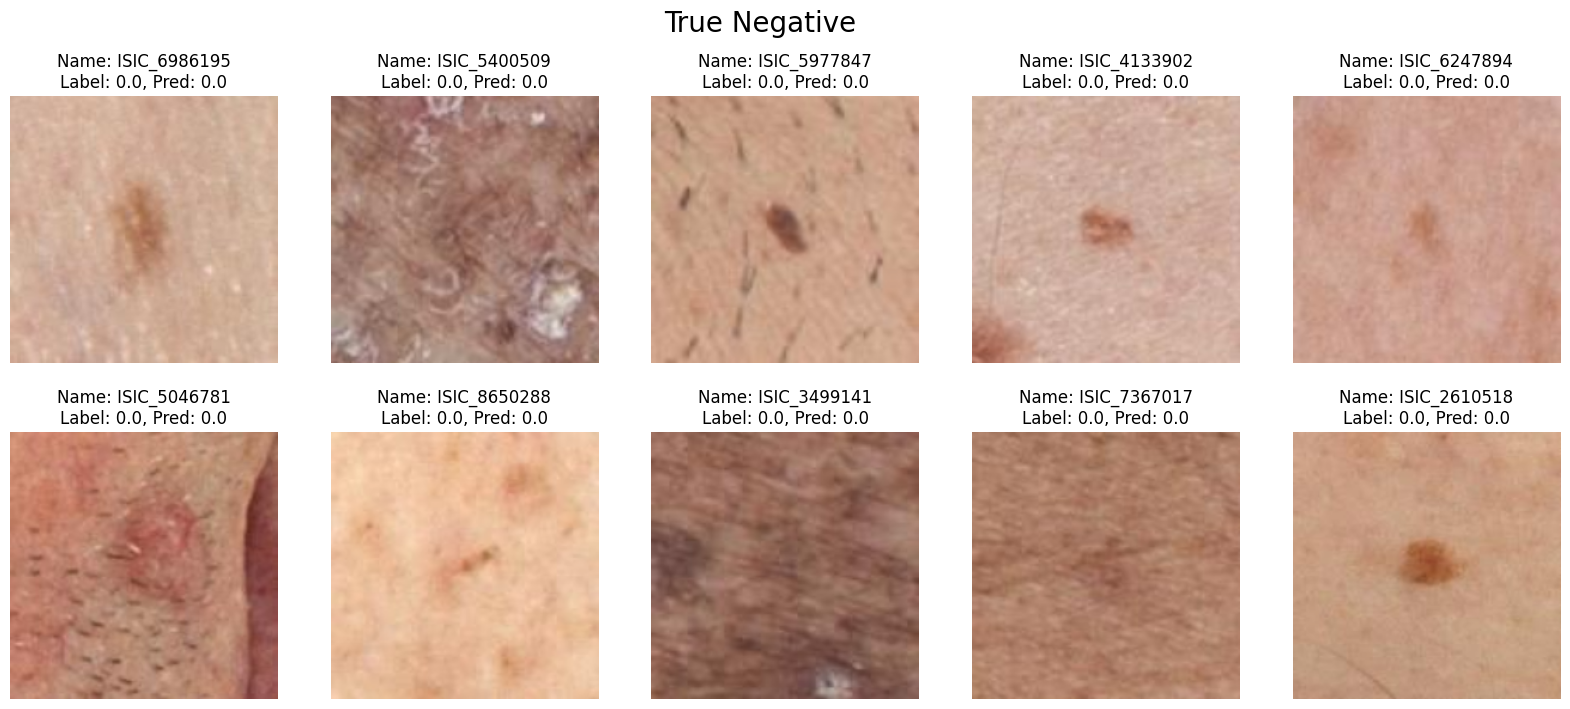

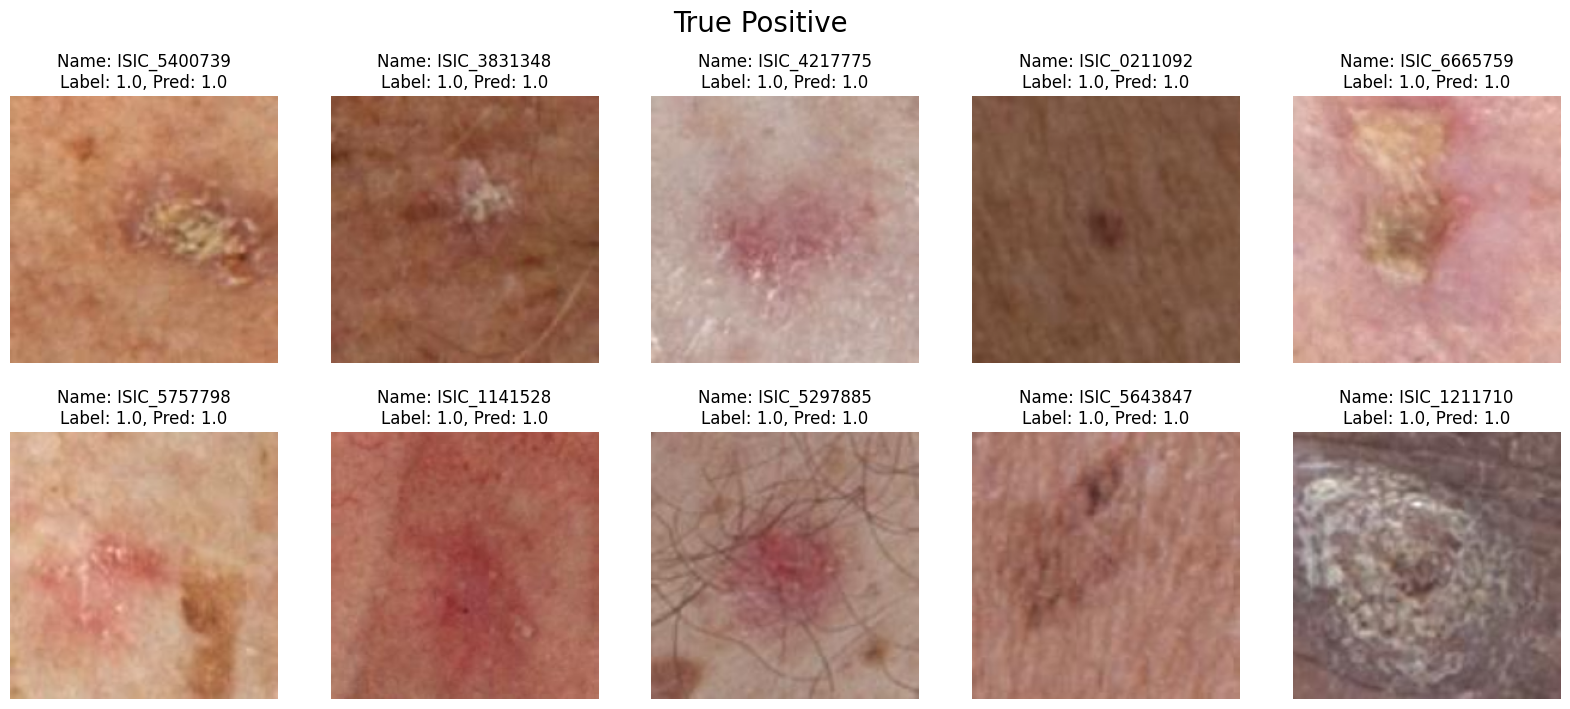

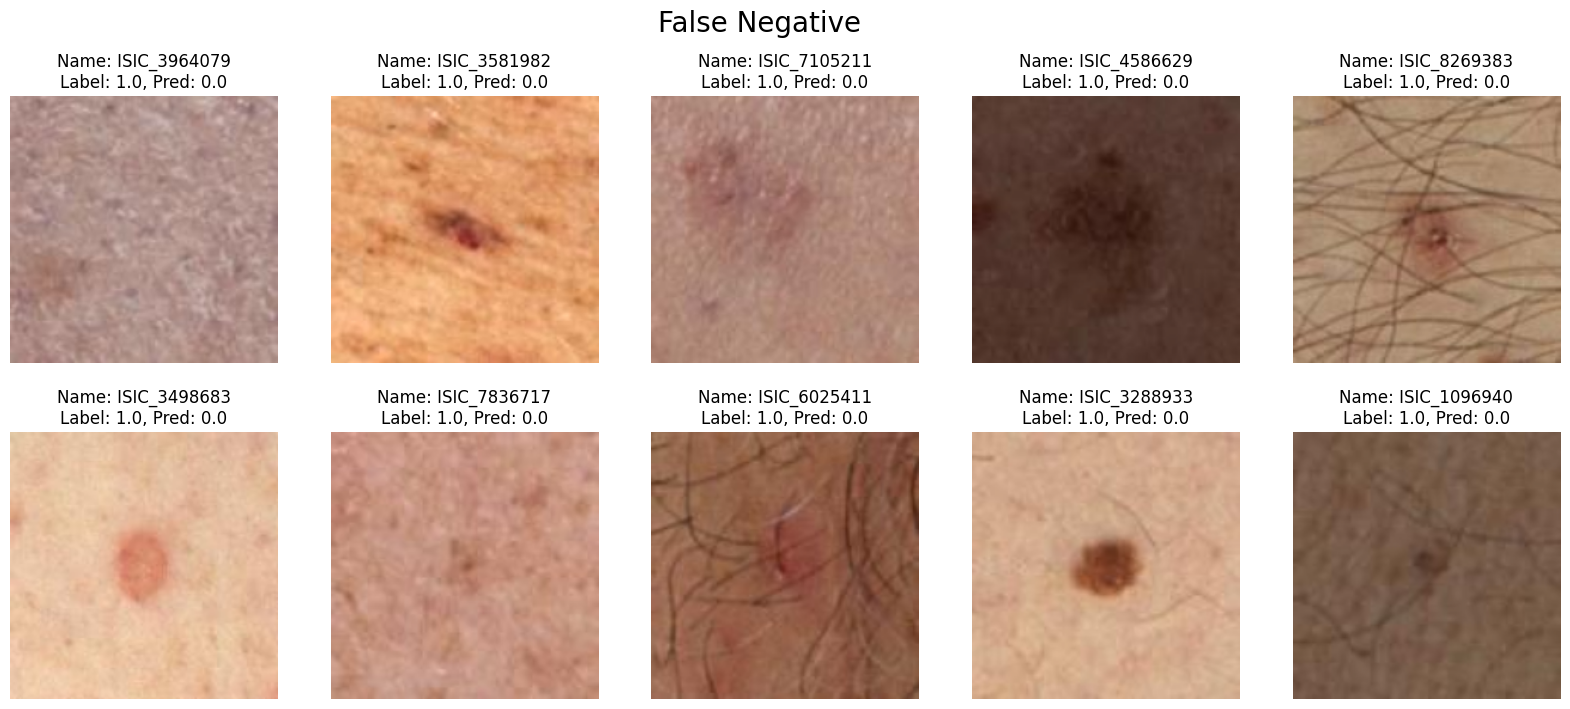

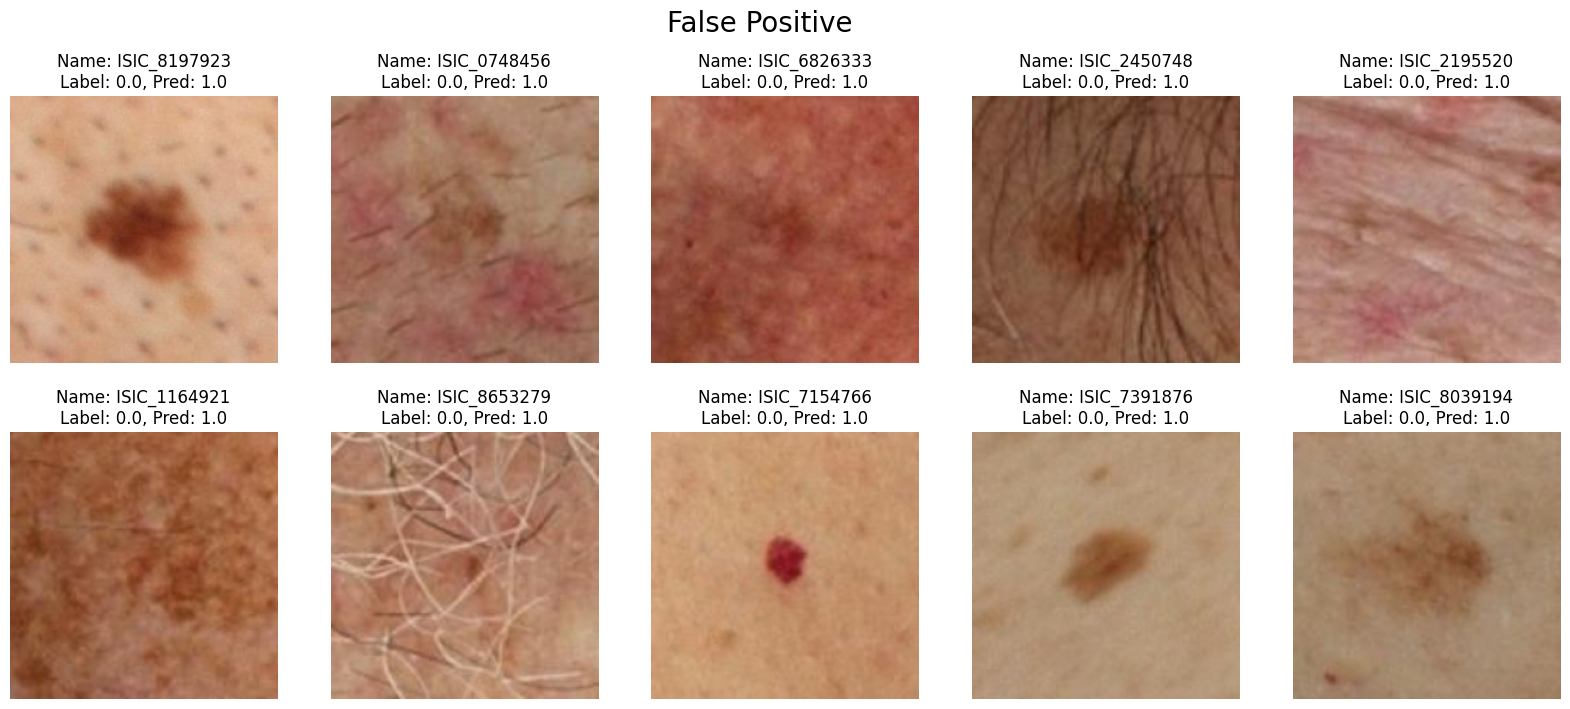

In [8]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Define the inverse normalization transformation
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def display_images(images, labels, preds, names, title):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(title, fontsize=20)
    for i, (img, label, pred, name) in enumerate(zip(images, labels, preds, names)):
        ax = axes[i // 5, i % 5]
        img = inv_normalize(img)  # Undo normalization
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Name: {name}\nLabel: {label.item()}, Pred: {pred.item()}")
        ax.axis('off')
    # Hide any remaining subplots if there are fewer than 10 images
    for j in range(i + 1, 10):
        axes[j // 5, j % 5].axis('off')
    plt.show()

def get_images_by_type(dataloader, model, device, type, num_images=10):
    images, labels, preds, names = [], [], [], []
    model.eval()
    with torch.no_grad():
        for img_batch, label_batch, name_batch in dataloader:
            img_batch, label_batch = img_batch.to(device), label_batch.to(device).float().unsqueeze(1)
            output_batch = model(img_batch)
            pred_batch = torch.sigmoid(output_batch)
            pred_batch = (pred_batch > 0.5).float()
            for img, label, pred, name in zip(img_batch, label_batch, pred_batch, name_batch):
                if type == 'true_negative' and label == 0 and pred == 0:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'true_positive' and label == 1 and pred == 1:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'false_negative' and label == 1 and pred == 0:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'false_positive' and label == 0 and pred == 1:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                if len(images) >= num_images:
                    return images, labels, preds, names
    return images, labels, preds, names

types = ['true_negative', 'true_positive', 'false_negative', 'false_positive']
for type in types:
    images, labels, preds, names = get_images_by_type(valloader, deit, device, type)
    display_images(images, labels, preds, names, type.replace('_', ' ').title())